In [79]:
import warnings

import itertools

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import quad
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
df = pd.read_csv('TOTALNSA.csv')
df.head()

,DATE,TOTALNSA
0,1976-01-01,885.2
1,1976-02-01,994.7
2,1976-03-01,1243.6
3,1976-04-01,1191.2
4,1976-05-01,1203.2


In [96]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')

In [26]:
df.head()

,DATE,TOTALNSA
0,1976-01-01,885.2
1,1976-02-01,994.7
2,1976-03-01,1243.6
3,1976-04-01,1191.2
4,1976-05-01,1203.2


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      543 non-null    datetime64[ns]
 1   TOTALNSA  543 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [28]:
df.set_index('DATE', inplace= True)

In [29]:
df.describe()

,TOTALNSA
count,543.000000
mean,1262.218814
std,225.750208
min,670.466000
25%,1112.650000
50%,1269.113000
75%,1427.000000
max,1845.713000


In [32]:
filtered_df = df.copy()
filtered_df = filtered_df.loc[(filtered_df.index >= '1976-01-01')
                     & (filtered_df.index  <= '2019-11-01')]

In [33]:
filtered_df.head()

,TOTALNSA
DATE,
1976-01-01,885.2
1976-02-01,994.7
1976-03-01,1243.6
1976-04-01,1191.2
1976-05-01,1203.2


In [34]:
filtered_df.describe()

,TOTALNSA
count,527.000000
mean,1261.759765
std,225.734608
min,670.466000
25%,1109.089500
50%,1270.600000
75%,1429.300000
max,1845.713000


In [35]:
filtered_df.columns = ['Total_Sales']

In [37]:
filtered_df.index.rename('Date', inplace= True)

In [38]:
filtered_df.head()

,Total_Sales
Date,
1976-01-01,885.2
1976-02-01,994.7
1976-03-01,1243.6
1976-04-01,1191.2
1976-05-01,1203.2


In [39]:
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 527 entries, 1976-01-01 to 2019-11-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_Sales  527 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


## Visualizing the Data

<Axes: xlabel='Date'>

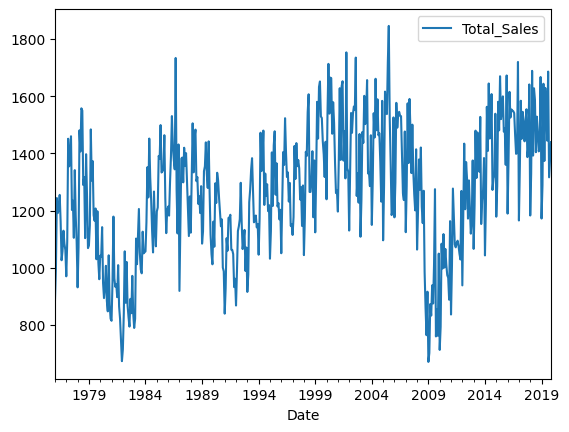

In [45]:
filtered_df.plot()

<Figure size 640x480 with 0 Axes>

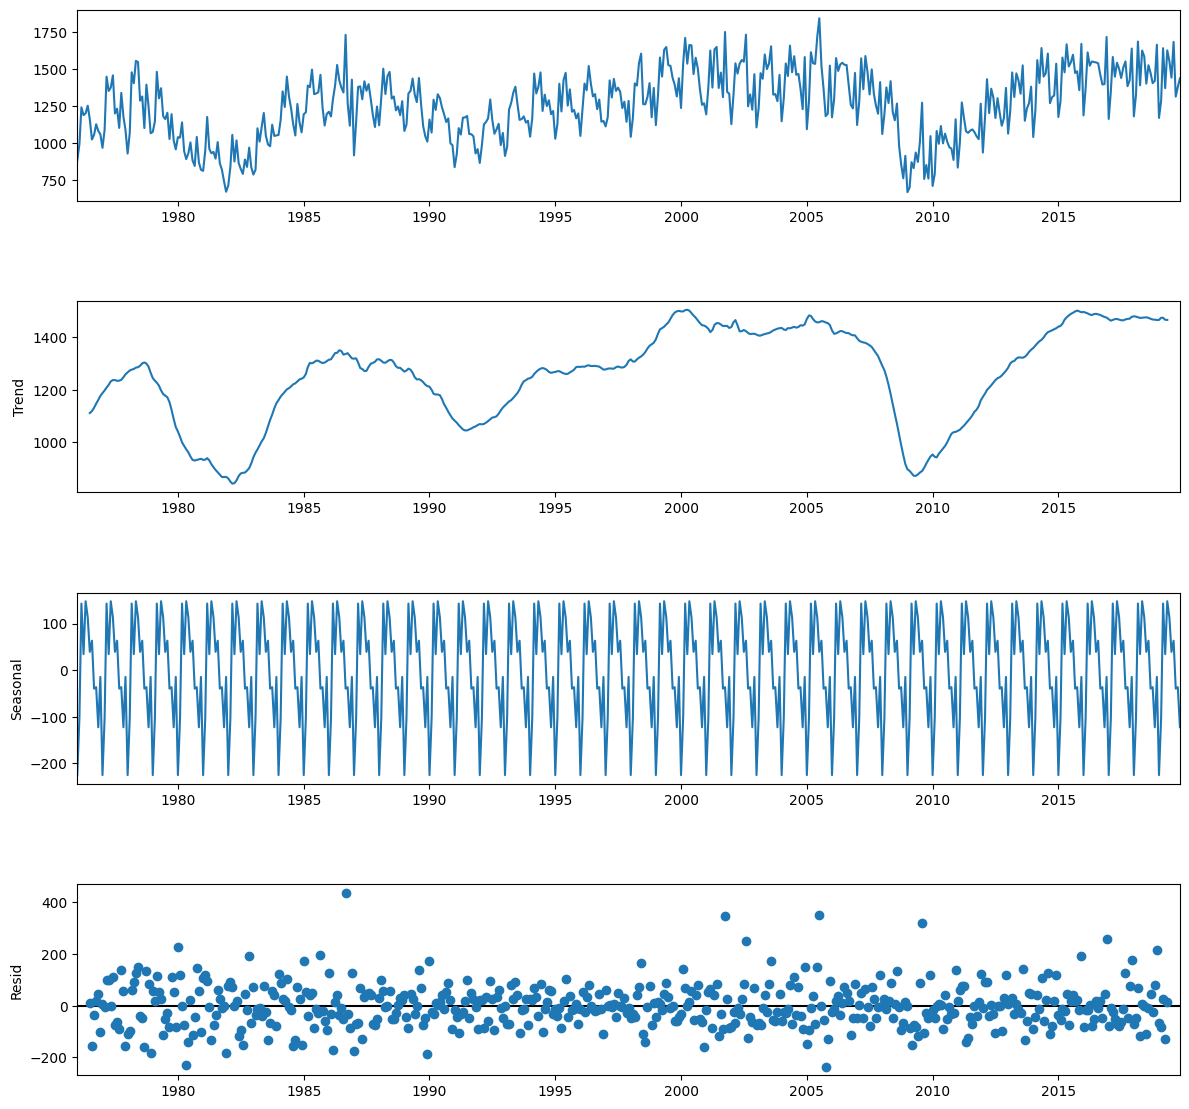

In [64]:
# decompose the data

decomposition = seasonal_decompose(filtered_df, period=12)
figure = plt.figure();
figure = decomposition.plot();  
figure.set_size_inches(13, 12);

The trends in data imply the data has seasonality. In order to factor that we will take seasonal difference.

### Differencing

<Axes: xlabel='Date'>

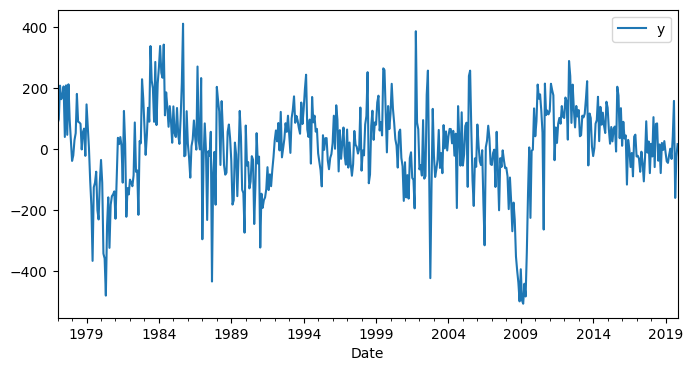

In [74]:
diff_seasonal = (filtered_df - filtered_df.shift(12)).dropna()
diff_seasonal.columns = ['y']

diff_seasonal.plot(figsize=(8, 4))

The data is still not stationary, so we will take one more difference.

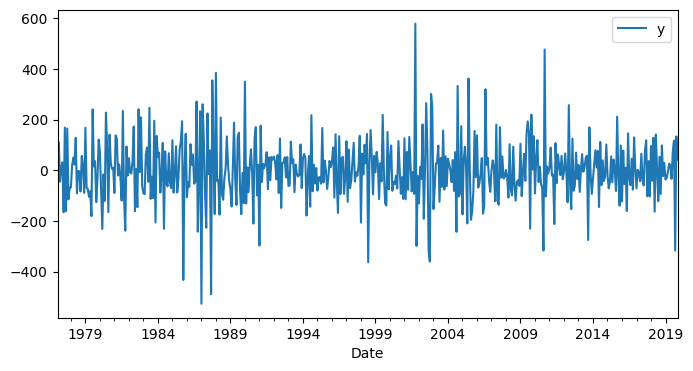

In [75]:

diff_seasonal_1 = (diff_seasonal - diff_seasonal.shift(1)).dropna()

diff_seasonal_1.plot(figsize=(8, 4));

The data appears to be stationary, we can confirm the results with Dickey Fuller test.

In [76]:
#H0: It is  Stationary
#H1: It is non Stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Substantial evidence against the null hypothesis(Ho), hence the null hypothesis is rejected. Data has no unit root and is stationary")
    else:
        print("Faint evidence against null hypothesis, time series has a unit root, implying it is non-stationary ")


In [77]:
adfuller_test(diff_seasonal_1)

ADF Test Statistic : -8.364565091372544
p-value : 2.7652295949332985e-13
#Lags Used : 12
Number of Observations Used : 501
Substantial evidence against the null hypothesis(Ho), hence the null hypothesis is rejected. Data has no unit root and is stationary


### Autocorrelation and Partial Autocorrelation

- Partial Autocorrelation is one of the best way to identify an Auto Regressive model.
- Autocorrelation is often used to identify Moving Average model.
    - p - Auto Regressive Lags,
- d - Differencing,
- q - Moving Avg Lags


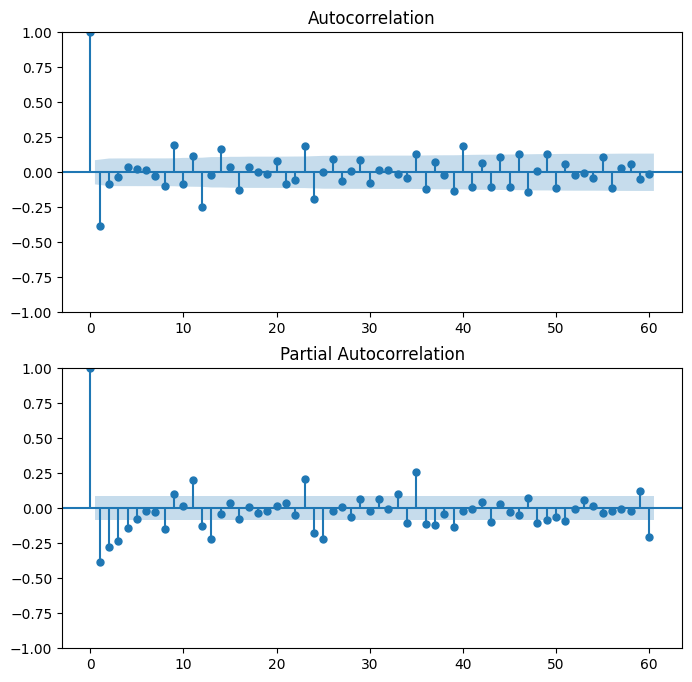

In [82]:
# use ACF and PACF to check the autocorrelation after differencing

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(diff_seasonal_1, lags=60, ax=ax1)
plot_pacf(diff_seasonal_1, lags=60, ax=ax2)
plt.show()

- In PACF, the spikes at lag 1,2,3 and 4 implies non-seasonal p (AR lags) value of 4 and the spike at lag 12 implies seasonality, and the seasonal p = 1.

- In ACF the spike at lag 1 implies non-seasonal q (MA) value of 1 and a significant spike at 12 implies a seasonal q value of 1.
- The seasonal difference has been appliedonce , so the d value would be 1.



### Model Training

In [86]:
model = sm.tsa.statespace.SARIMAX(df,order=(4,1,1), seasonal_order=(1,1,1,12))
ARIMAresult = model.fit(maxiter=100)
print(ARIMAresult.summary())

c:\Users\vamsi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vamsi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           TOTALNSA   No. Observations:                  543
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3192.053
Date:                            Sun, 26 Feb 2023   AIC                           6400.106
Time:                                    21:18:30   BIC                           6434.289
Sample:                                01-01-1976   HQIC                          6413.486
                                     - 03-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4581      0.030     15.467      0.000       0.400       0.516
ar.L2          0.1443      0.044   

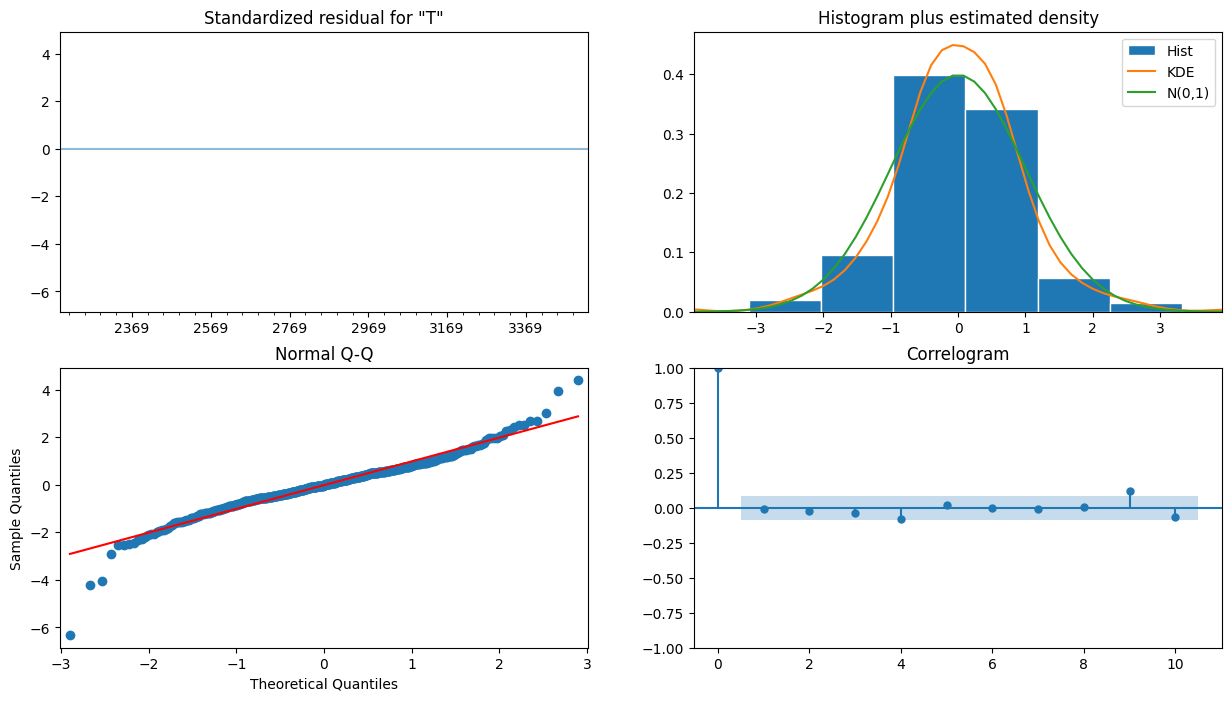

In [103]:
ARIMAresult.plot_diagnostics(figsize=(15, 8))
plt.show()

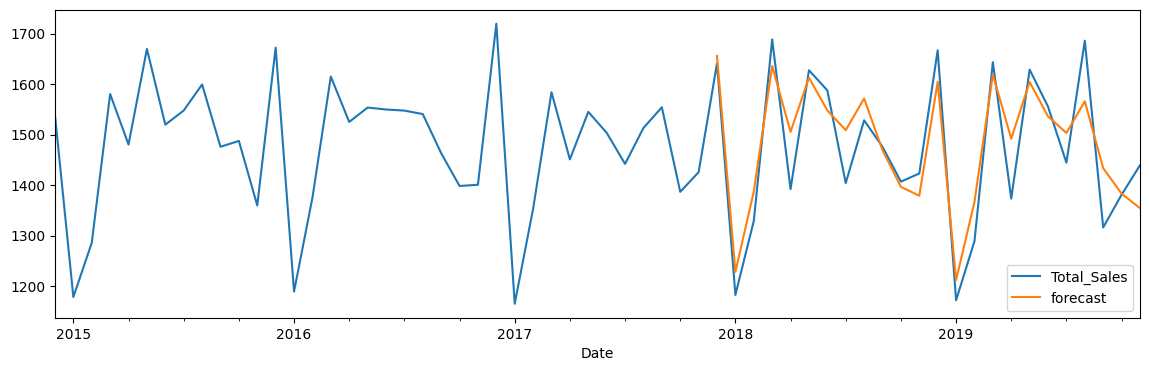

In [122]:
filtered_df['forecast']=ARIMAresult.predict(start=503,end=540,dynamic=True)
x = filtered_df[-60:]
x[['Total_Sales','forecast']].plot(figsize=(14,4));

In [123]:
# calculating Mean Absolute Error and Mean Absolute Percentage Error to evaluate the performance

a = mean_absolute_error(filtered_df['Total_Sales'][-12:], filtered_df['forecast'][-12:])
b = a/(filtered_df['Total_Sales'][-12:]).mean()*100

print('Mean Absolute Error is {}'.format(round(a, 1)))
print('Mean Absolute Percentage Error is {}%'.format(round(b, 1)))

Mean Absolute Error is 62.5
Mean Absolute Percentage Error is 4.3%


Mean Absolute Percentage Error of 4.3% implies the model is performing well and we can use the model to make future prediction 

## Future prediction

In [111]:
from pandas.tseries.offsets import DateOffset
future_dates=[filtered_df.index[-1]+ DateOffset(months=x)for x in range(0,12)]

In [112]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=filtered_df.columns)

In [113]:
future_datest_df.shape

(11, 2)

In [114]:
future_df=pd.concat([filtered_df, future_datest_df])

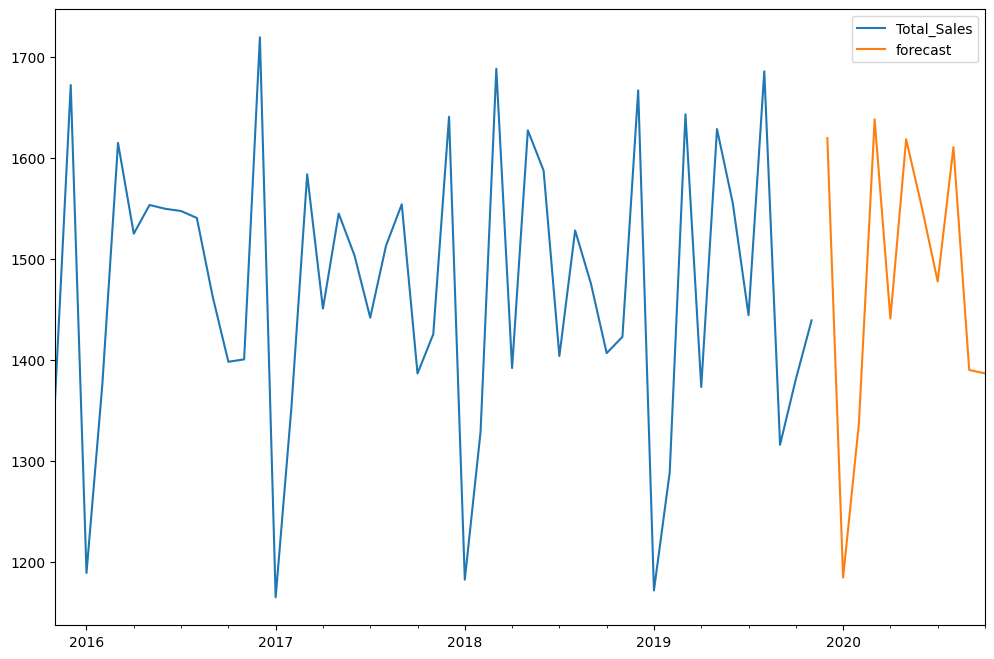

In [121]:
# Last five years

future_df['forecast'] = ARIMAresult.predict(start = 527, end = 539, dynamic= True)
z = future_df[-60:]
z[['Total_Sales', 'forecast']].plot(figsize=(12, 8));
